<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/build/el-paso-workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [7]:
%%capture
!pip install --progress-bar off poetry
!pip install --progress-bar off git+https://github.com/oughtinc/ergo.git@8578059fa41f9ba217dff90fa323a35842d5e033

In [8]:
import warnings
import ssl
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="plotnine")
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
import ergo
import seaborn

import numpy as np
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt

pd.set_option('precision', 2)

def summarize_samples(samples):
    stats = samples.describe(percentiles=[0.05, 0.5, 0.95])
    percentile = lambda pt: float(stats.loc[f"{pt}%"])
    return f"{percentile(50):.2f} ({percentile(5):.2f} to {percentile(95):.2f})"

def show_marginal(func):
    samples = ergo.run(func, num_samples=1000)
    seaborn.distplot(samples).set_title(func.__doc__);
    plt.show()
    print(f"Median {func.__doc__}: {summarize_samples(samples)}")

# Choose a decision-relevant question

## How many ventilators will be needed in El Paso?

I want to predict on this question:

> How many patients with Covid-19 in El Paso County will require invasive ventilation on the day when the number of hospital patients of cases peak?

Background:

- El Paso is a county in Texas (population 850,000)
- They're preparing for the impact of COVID-19
- This questions is part of a series of a dozen questions that have been formulated in partnership between [Metaculus](https://www.metaculus.com) and administrators at Texas Tech University Health Sciences Center, El Paso
- The answers on Metaculus will guide on-the-ground decision
- This questions is particularly decision-relevant: it's important to have enough ventilators on the day when most are needed, but if you don't need them, they might be put to better use elsewhere

## Loading question data from the Metaculus crowd prediction platform

Ergo can read and write from Metaculus, Foretold, and other crowd prediction sites.

I'll load [this question](https://pandemic.metaculus.com/questions/4137/) from Metaculus:

In [10]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456", api_domain="pandemic")
peak_ventilators_question = metaculus.get_question(4201, name="# ventilators needed on peak day")
peak_ventilators_question

This will allow us to compare our prediction to the Metaculus community, and to submit our prediction to the platform.

# A guess

I'll start by making an uninformed guess. I'll do this before I look at any data or anyone else's predictions. That way, I can look back to this guess to see what I learn as I go through the forecasting process.

What is my 90% confidence interval for the number of ventilators needed? I think there is a 

- less than 5% chance that <3 people require ventilation
- less than 5% chance that >100 people require ventilation

So I'll go with a 90% confidence interval of [3, 100].

I don't know much about El Paso, ICUs, or ventilators. I feel pretty uncertain and assign non-negligible probability to higher values. I'll go with a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), which will assign more probability to the "right tail" of higher values than a normal distribution.

## Distributions in Ergo

In Ergo, I can generate a single sample from this distribution like this:

In [11]:
ergo.lognormal_from_interval(3, 100)

DeviceArray(20.191326, dtype=float32)

To get many samples, I use `ergo.run`:

In [12]:
def peak_ventilators():
    "# ventilators needed on peak day"
    return ergo.lognormal_from_interval(3, 100)

samples = ergo.run(peak_ventilators, num_samples=1000)

samples

,output
0,91.75
1,4.04
2,21.08
3,82.26
4,49.40
...,...
995,14.95
996,10.95
997,6.60
998,7.30


Why sample? As we build out our model, we'll see that: 

- Composing samplers is easy - it's just programming as usual
- Composing probability distributions is hard - it's math

We'll build up complex models by composing samplers.

## Visualizing distributions

I can visualize these samples using my question's `show_prediction` method:

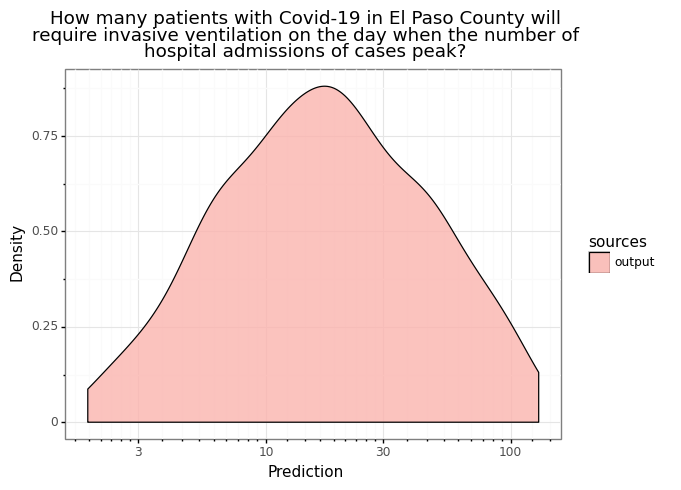

In [13]:
peak_ventilators_question.show_prediction(samples)

# Model V1: My guess

I'll wrap my guess in a `Model` class so that I can more easily build on it step by step by inheriting from the class, adding more methods, and replacing methods with better implementations:

In [14]:
class ModelV1:
    
    def peak_ventilators(self):
        "# ventilators needed on peak day"
        return ergo.lognormal_from_interval(3, 100)

    def run(self):
        samples = ergo.run(self.peak_ventilators, num_samples=1000)
        peak_ventilators_question.show_prediction(samples); plt.show()
        print(f"Median # ventilators needed: {summarize_samples(samples)}")

This doesn't change the result:

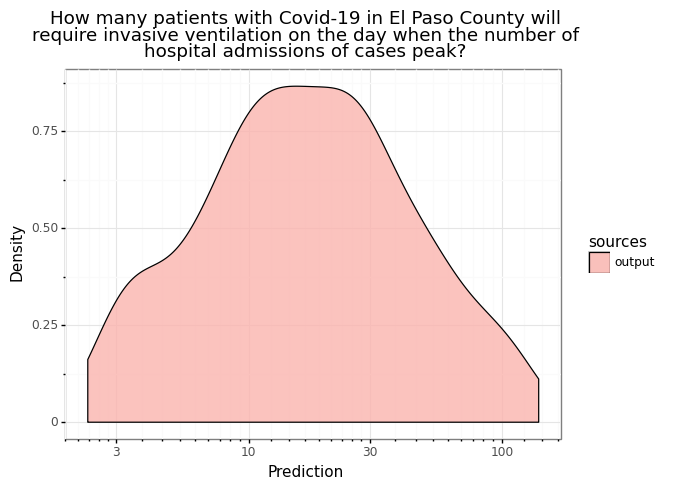

Median # ventilators needed: 16.87 (2.91 to 102.11)


In [15]:
ModelV1().run()

It's still an uninformed guess.

# Model V2: Decomposing the ventilation question

## My decomposition

My strategy for this question will be to break it into pieces and then improve my estimate for each piece. I'll start by estimating the peak ventilators needed as the product of:

1. How many patients will be in the ICU on the day of peak hospitalizations?
2. What fraction of those will need ventilators?

So my decomposition looks like this:

- \# ventilators needed on peak day =
  - \# icu patients on peak day *
  - % of icu patients requiring ventilation
 
For both of these I'll make pretty uninformed guesses for now:

1. I guess that about 5 to 200 people will be in the ICU on peak day (but I have no idea)
2. I'd guess that 1 out of 3 will need ventilators (but I have no idea)

For ICU cases, I use the same `lognormal_from_interval` function I used above. I'll always show components of my model in blue and the overall model prediction in red:

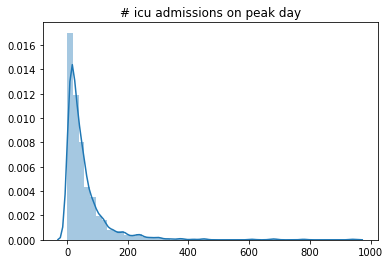

Median # icu admissions on peak day: 35.34 (5.51 to 188.67)


In [16]:
def peak_icu_patients():
    "# icu patients on peak day"
    return ergo.lognormal_from_interval(5, 200)

show_marginal(peak_icu_patients)

For ventilation need, I'll use a [beta-binomial distribution](http://varianceexplained.org/statistics/beta_distribution_and_baseball/):

In [17]:
def frac_icu_ventilation():
    "% of icu patients requiring ventilation"
    return ergo.beta_from_hits(1, 3)

This distribution looks like this:

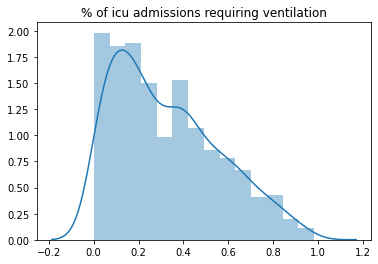

Median % of icu admissions requiring ventilation: 0.28 (0.02 to 0.78)


In [18]:
show_marginal(frac_icu_ventilation)

## The new model

My model now looks like this:

In [19]:
class ModelV2(ModelV1):
    
    def peak_ventilators(self):
        "# ventilators needed on peak day"
        return self.frac_icu_ventilation() * self.peak_icu_patients()   
    
    def peak_icu_patients(self):
        "# icu patients on peak day"
        return ergo.lognormal_from_interval(5, 200)

    def frac_icu_ventilation(self):
        "% of icu patients requiring ventilation"
        return ergo.beta_from_hits(1, 3)

This doesn't change the overall estimate much:

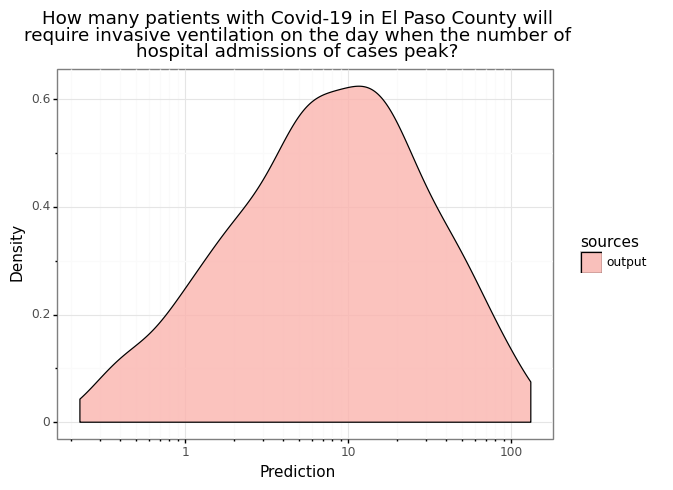

Median # ventilators needed: 8.23 (0.43 to 86.89)


In [20]:
ModelV2().run()

# Model V3: A better estimate for the fraction of ICU patients needing ventilation

I want to improve my estimate for the fraction of ICU patients that need ventilation:

- \# ventilators needed on peak day =
  - \# icu patients on peak day *
  - **% of icu patients requiring ventilation**

I'll do this by looking at [data from publications](https://pandemic.metaculus.com/questions/4154/#comment-28155). This is the approach followed by PabloStafforini et al on Metaculus.

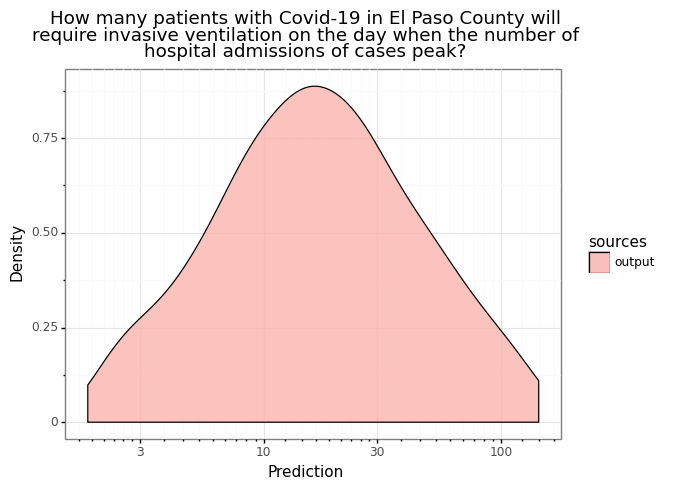

Median # ventilators needed: 16.27 (2.53 to 105.84)


In [21]:
class ModelV3(ModelV2):

    def frac_icu_ventilation(self):
        "% of icu patients requiring ventilation"
        ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
        icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
        return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

model_v3 = ModelV3()

model_v3.run()

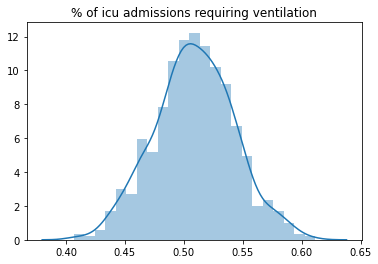

Median % of icu admissions requiring ventilation: 0.51 (0.45 to 0.57)


In [22]:
show_marginal(model_v3.frac_icu_ventilation)

This increased the overall estimate since I'd assumed that about 1/3 people need ventilation, but the empirical data says that about 1/2 do.

# Model V4: Decomposing the peak ICU patients question

Now I want to better estimate the number of ICU patients at peak. I'll break it down into:

1. What's the maximum number of hospital patients at peak?
2. What fraction of those need to go to the ICU?

So my new decomposition looks like this:

- \# ventilators needed on peak day =
  - **\# icu patients on peak day** *
    - **\# patients on peak hospitalization day** *
    - **% of patients in icu**
  - % of icu patients requiring ventilation
    - average found in literature (pablo)

I'll again start by making pretty uninformed guesses for both of these questions. I assume that:

1. There's about 10 to 100 COVID-19 hospital patients per day at peak
2. About half of those need to be in the ICU

In [23]:
class ModelV4(ModelV3):

    def peak_icu_patients(self):
        "# icu patients on peak day"
        max_patients = self.max_30d_hospital_confirmed_for_peak()
        return max_patients * self.frac_patients_icu()
    
    def max_30d_hospital_confirmed_for_peak(self):
        "# patients on peak day"        
        return ergo.lognormal_from_interval(10, 100)
    
    def frac_patients_icu(self):
        "% of patients going to icu"
        return ergo.beta_from_hits(1, 2)    

model_v4 = ModelV4()

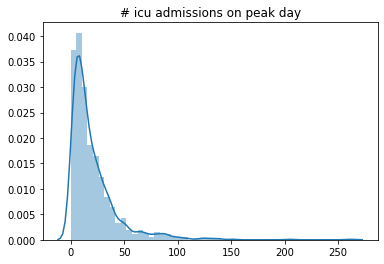

Median # icu admissions on peak day: 13.49 (1.36 to 66.70)


In [24]:
show_marginal(model_v4.peak_icu_patients)

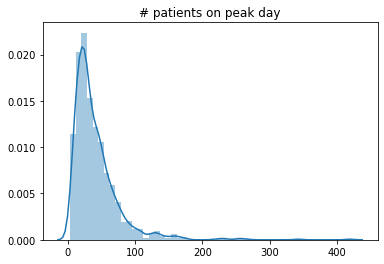

Median # patients on peak day: 30.92 (9.82 to 101.60)


In [25]:
show_marginal(model_v4.max_30d_hospital_confirmed_for_peak)

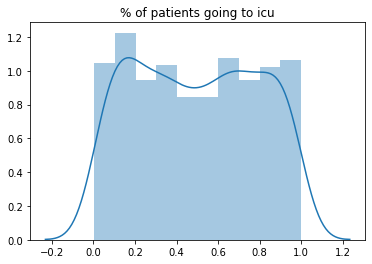

Median % of patients going to icu: 0.49 (0.05 to 0.95)


In [26]:
show_marginal(model_v4.frac_patients_icu)

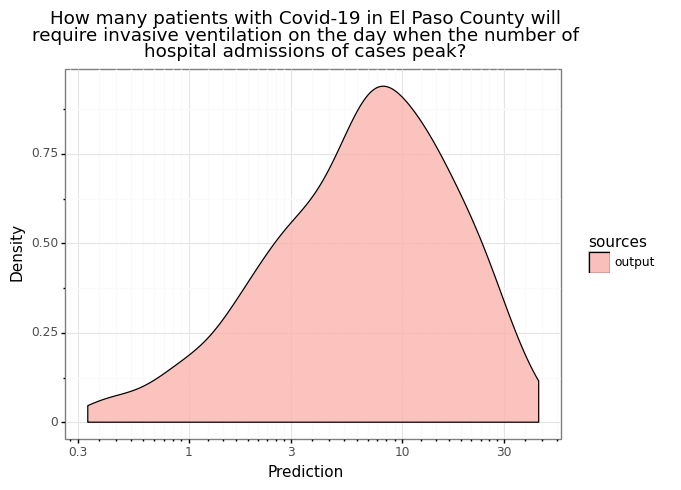

Median # ventilators needed: 7.23 (0.74 to 31.70)


In [27]:
model_v4.run()

# Model V5: A better estimate for the fraction of patients that need to be in  the ICU

To get a real estimate for the number of hospital patients that need to go to the ICU, I'll look at what happened in other countries. This is [the approach followed by katifish](https://pandemic.metaculus.com/questions/4155/#comment-28054) on Metaculus.

So model 5 looks like this:

- \# ventilators needed on peak day =
  - \# icu patients on peak day *
    - \# patients on peak hospitalization day *
    - **% of patients going to icu**
      - **empirical results in other countries (katifish)**
  - % of icu patients requiring ventilation
    - average found in literature (pablo)

In [28]:
class ModelV5(ModelV4):
    
    def frac_patients_icu(self):
        "% of patients going to icu"
        alpha = 0.1 # Rescaling counts becase we're more uncertain than implied by counts
        return ergo.random_choice([
          ergo.beta_from_hits(alpha * 121, alpha * 508),
          ergo.beta_from_hits(alpha * 181, alpha * 507),
        ])

model_v5 = ModelV5()

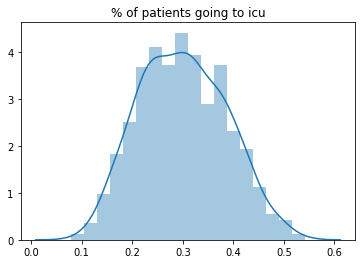

Median % of patients going to icu: 0.30 (0.16 to 0.44)


In [29]:
show_marginal(model_v5.frac_patients_icu)

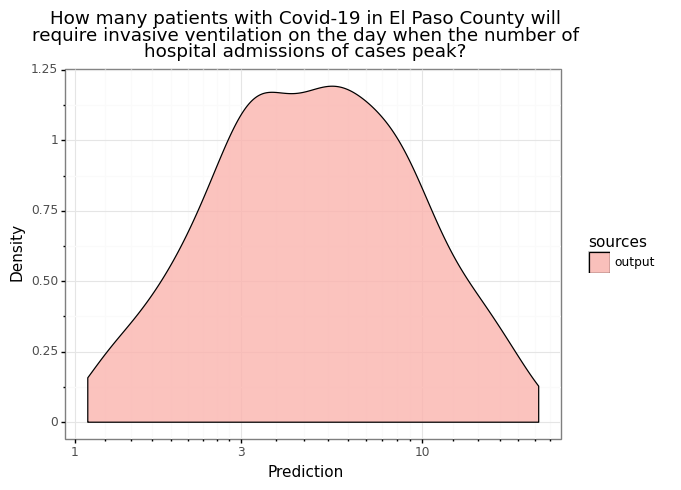

Median # ventilators needed: 4.89 (1.33 to 16.80)


In [30]:
model_v5.run()

# Model V6: Decomposing the maximum-patients question

What is the maximum number of people in the hospital around peak infection time? I'll break this one down into:

1. When is the peak infection date?
2. What is the largest number of people in the hospital in the 30-day period around this date?

Model 6 looks like this:

- \# ventilators needed on peak day =
  - \# icu patients on peak day *
    - **\# patients on peak hospitalization day** *
      - **when is peak infection day?**
      - **max daily hospitalizations within 30 days of peak infection day**
    - % of patients going to icu
      - empirical results in other countries (katifish)
  - % of icu patients requiring ventilation
    - average found in literature (pablo)


Again I'll start with uninformed guesses.

In [31]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)


class ModelV6(ModelV5):
    
    def max_30d_hospital_confirmed_for_peak(self):
        "# patients on peak hospitalization day"        
        peak = self.peak_infection_date()
        days = daterange(peak - timedelta(15), peak + timedelta(15))
        return max(self.hospital_confirmed_for_date(day) for day in days)    
    
    def peak_infection_date(self) -> date:
        "when is peak infection day?"
        start_date = date(2020, 4, 1)                
        end_date = date(2020, 7, 1)        
        return ergo.random_choice(list(daterange(start_date, end_date)))
    
    def hospital_confirmed_for_date(self, date: date) -> int:
        "how many hospitalizations on any given day?"
        return ergo.lognormal_from_interval(10, 100)    

model_v6 = ModelV6()

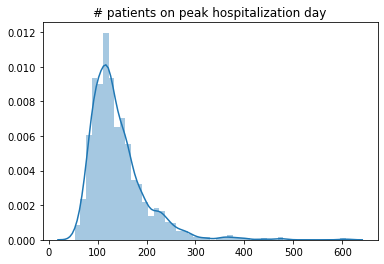

Median # patients on peak hospitalization day: 126.56 (80.14 to 243.48)


In [32]:
show_marginal(model_v6.max_30d_hospital_confirmed_for_peak)

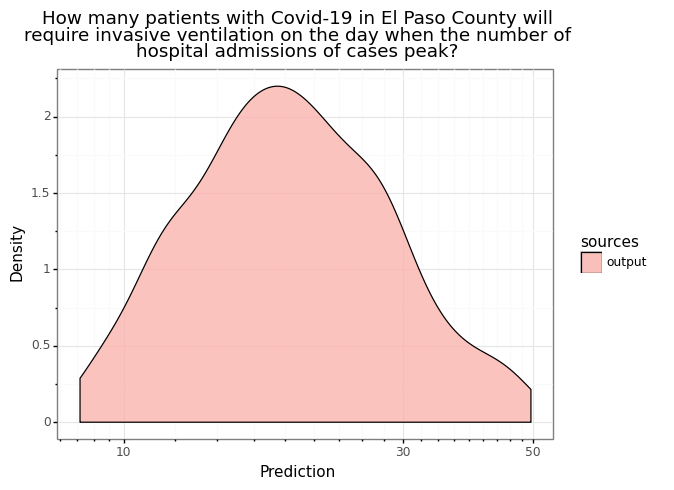

Median # ventilators needed: 18.87 (9.45 to 42.33)


In [33]:
model_v6.run()

# Model V7: A better estimate for peak infection date and hospitalizations

To better estimate peak infection date and hospitalizations, I need actual data. A lot happens here, sorry! Please skip.

In [34]:
from ergo.contrib.el_paso import *

START_DATE = date(2020, 4, 1)
el_paso_cases = texas_data.get_el_paso_data()
get_daily_hospital_confirmed = brachbach.get_daily_hospital_confirmed
compiled_data = krismoore.get_krismoore_data()
projected_cases = onlyasith.get_onlyasith_results()

In [35]:
class ModelV7(ModelV6):
    
    def __init__(self):
        self.hospital_confirmed_from_daily_infected_model = get_daily_hospital_confirmed(compiled_data, self.daily_infections)
        super(ModelV7, self).__init__()

    def peak_infection_date(self) -> date:
        "when is peak infection day?"
        end_date = date(2020, 7, 1)
        for today in daterange(START_DATE, end_date):
            sma_today = self.sma_infections(today)
            future_smas = [self.sma_infections(today + timedelta(i)) for i in range(1,11)]
            if sma_today > max(future_smas):
                return today
        return end_date
        
    def hospital_confirmed_for_date(self, date: date) -> int:
        "how many hospitalizations on any given day?"
        try:
            # Look up in-hospital confirmed cases from @KrisMoore's compiled data
            new_hospital_confirmed = compiled_data.loc[date, "In hospital confirmed"]
            if np.isnan(new_hospital_confirmed):
                raise KeyError
            return new_hospital_confirmed
        except KeyError:
            try:
                # Get point estimate from @brachbach's regression model
                cases = self.hospital_confirmed_from_daily_infected_model(date)

                # Add some (fairly arbitrary) uncertainty around this point estimate
                if cases == 0:
                    return cases
                cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
                return np.clip(cases_estimate, cases * 0.5, cases * 2)
            except KeyError:
                return 0
        
    def daily_infections(self, date: date) -> int:
        "reported new infections per day"
        try:
            # Look up Texas Government data
            new_cases = el_paso_cases.loc[date, "New cases"]
            if np.isnan(new_cases):
                raise KeyError
            return new_cases
        except KeyError:
            try:
                # Look up projections from @onlyasith's model
                cases = projected_cases.loc[date, "New cases"]
                if np.isnan(cases):
                    raise KeyError

                # Add some (fairly arbitrary) uncertainty around this point estimate
                if cases == 0:
                    return cases
                cases_estimate = ergo.lognormal_from_interval(cases * 0.8, cases * 1.2)
                return np.clip(cases_estimate, cases * 0.5, cases * 2)
            except KeyError:
                # We're beyond the time range for data and model
                return 0

    def mean_infections(self, start_date: date, end_date: date):
        "mean daily infections (including start date, excluding end date)"
        days = daterange(start_date, end_date)
        return np.mean([self.daily_infections(day) for day in days])

    def sma_infections(self, date: date):
        """
        The simple moving average of infections for a date.

        Defined in https://pandemic.metaculus.com/questions/4128:

        'The 2-day SMA is defined as the unweighted average (arithmetic mean)
        over the current day and the previous day.'
        """
        return self.mean_infections(date - timedelta(1), date + timedelta(1))    

model_v7 = ModelV7() 

[datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26), datetime.date(2020, 4, 26)]


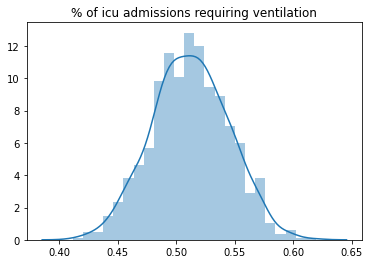

Median % of icu admissions requiring ventilation: 0.51 (0.46 to 0.57)


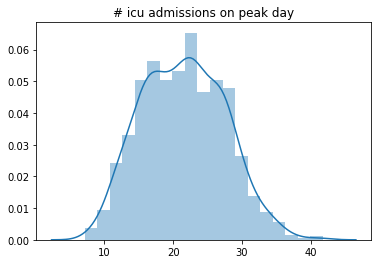

Median # icu admissions on peak day: 21.48 (12.14 to 31.19)


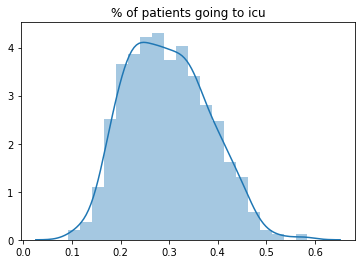

Median % of patients going to icu: 0.29 (0.17 to 0.44)


RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

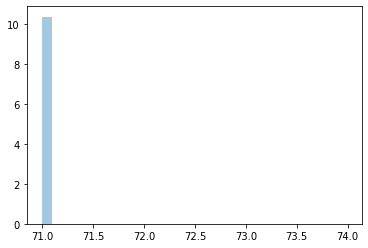

In [36]:
print([model_v7.peak_infection_date() for _ in range(10)])
show_marginal(model_v7.frac_icu_ventilation)
show_marginal(model_v7.peak_icu_patients)
show_marginal(model_v7.frac_patients_icu)
show_marginal(model_v7.max_30d_hospital_confirmed_for_peak)

In [ ]:
model_v7.run()

# Review

My original question was:

> How many patients with Covid-19 in El Paso County will require invasive ventilation on the day when the number of hospital patients of cases peak?

My final answer is that a median of 10.5 people will require ventilation.

We arrived at this answer by breaking it down as follows:

- \# ventilators needed on peak day [10.48 (6.39 to 16.07)] =
  - \# icu patients on peak day [21.45 (12.51 to 32.02)] *
    - \# patients on peak hospitalization day [71] *
      - when is peak infection day? [2020/4/26]
      - max daily hospitalizations within 30 days of peak infection day [71]
        - how many hospitalizations on any given day?
    - % of patients going to icu [0.30 (0.18 to 0.45)]
      - empirical results in other countries (katifish)
  - % of icu patients requiring ventilation [0.51 (0.46 to 0.57)]
    - average found in literature (pablo)

I'll compare my final prediction to the Metaculus community's:

In [ ]:
model_v7 = ModelV7()
samples = ergo.run(model_v7.peak_ventilators, num_samples=1000)
peak_ventilators_question.show_prediction(samples, show_community=True)

## Share my prediction

I'll submit my prediction to the Metaculus site to make the community prediction more accurate:

In [ ]:
# peak_ventilators_question.submit_from_samples(samples)